# Name : Muhammad Zaraar Malik
# Roll Numbers: 21i-2705
# Sections : AI-A

# **Import Necessary Libraries**

In [6]:
import time
import torch
import warnings
import torchvision
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.nn.init import xavier_uniform_
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")
warnings.filterwarnings('ignore')

Training on cuda


### **Mounting Drive to Save important items**

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### **Defining a Transformation Parameter for the CIFAR-10 Images**

In [4]:
# Define data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # CIFAR-10 stats
])

### **Defining Training and Testing Datasets**

In [5]:
# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 49138543.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **Vision Transformer Model**
### **It has 3 Parts**
* **Initial Compressed Representation**
* **Transformer Model**
* **Multi-Layer Preceptron**

In [7]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        # (seq_len, batch, embed_dim)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]  
        x = x + self.linear(self.layer_norm_2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=8, num_classes=10, embed_size=256, depth=6, heads=8, feedforward_dim=512, dropout=0.1):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.embed_size = embed_size
        self.depth = depth
        self.heads = heads
        self.feedforward_dim = feedforward_dim
        self.num_classes = num_classes

        # Patch embedding layer (divide image into patches)
        self.patch_embed = nn.Conv2d(3, embed_size, kernel_size=patch_size, stride=patch_size)

        # Positional encoding
        num_patches = (img_size // patch_size) ** 2
        self.positional_encoding = nn.Parameter(torch.randn(1, num_patches, embed_size))

        # Attention blocks (Transformer layers)
        self.transformer_blocks = nn.ModuleList([
            AttentionBlock(embed_size, feedforward_dim, heads, dropout)
            for _ in range(depth)
        ])

        # MLP head for classification
        self.fc = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, num_classes)
        )

    def forward(self, x):
        # Patch embedding: (batch_size, 3, 32, 32) -> (batch_size, num_patches, embed_size)
        x = self.patch_embed(x)  # (batch_size, embed_size, num_patches_sqrt, num_patches_sqrt)

        # Flatten and transpose to match the shape (batch_size, num_patches, embed_size)
        x = x.flatten(2).transpose(1, 2)  # (batch_size, num_patches, embed_size)

        # Add positional encoding
        x = x + self.positional_encoding

        # Pass through Transformer layers (Attention blocks)
        for block in self.transformer_blocks:
            x = block(x)

        # Global average pooling
        x = x.mean(dim=1)  # (batch_size, embed_size)

        # Classification head
        x = self.fc(x)  # (batch_size, num_classes)

        return x

### **Define Hyperparameters**

In [16]:
# Hyperparameters
lr = 1e-5  
batch_size = 64
epochs = 30
no_improvement = 5
best_acc = 0
# Gradient clipping (to prevent exploding gradients)
max_grad_norm = 1.0  
# Early stopping variables
counter = 0

IMG_SIZE=32
PATCH_SIZE=4
NUM_CLASSES=10
EMBEDDING_SIZE=256
MODEL_DEPTH=6
ATTENTION_HEADS=8
MLP_DIM=512
DROPOUT=0.1

### **Defining Training and Testing Loaders**

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### **Declare and Initialize Model, Loss Function, Optimizer, MLP Weights**

In [49]:
VIT = VisionTransformer(img_size=IMG_SIZE, patch_size=PATCH_SIZE, num_classes=NUM_CLASSES, embed_size=EMBEDDING_SIZE, 
                          depth=MODEL_DEPTH, heads=ATTENTION_HEADS, feedforward_dim=MLP_DIM, dropout=DROPOUT).to(device)

for m in model.modules():
    if isinstance(m, nn.Linear):
        xavier_uniform_(m.weight)  

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### **Train and Validate the Model**

In [50]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    start_time = time.time()

    VIT.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Train", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = VIT(inputs)

        # Ensure labels are in correct format (int) for CrossEntropyLoss
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    VIT.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} Val", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = VIT(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print((
        f"Epoch [{epoch+1}/{epochs}], "
        f"Train Loss: {train_loss:.4f}, "
        f"Train Acc: {train_acc:.2f}%, "
        f"Val Loss: {val_loss:.4f}, "
        f"Val Acc: {val_acc:.2f}%, "
        f"Time: {time.time() - start_time:.2f}s"
    ))

    # Check for improvement in validation accuracy and save the model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = VIT.state_dict()
        torch.save(best_model_wts, 'best_model.pth')  # Save checkpoint
        counter = 0  # Reset early stopping counter
    else:
        counter += 1

    # Early stopping: if no improvement in `patience` epochs, stop training
    if counter >= no_improvement:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

Epoch 1/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.83batch/s]


Epoch [1/30], Train Loss: 1.8321, Train Acc: 40.20%, Val Loss: 1.3974, Val Acc: 54.95%, Time: 22.65s


Epoch 2/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.18batch/s]


Epoch [2/30], Train Loss: 1.2310, Train Acc: 59.45%, Val Loss: 1.1234, Val Acc: 62.22%, Time: 22.88s


Epoch 3/30 Val: 100%|██████████| 157/157 [00:03<00:00, 43.92batch/s]


Epoch [3/30], Train Loss: 1.0605, Train Acc: 64.01%, Val Loss: 1.0233, Val Acc: 65.48%, Time: 22.95s


Epoch 4/30 Val: 100%|██████████| 157/157 [00:03<00:00, 43.98batch/s]


Epoch [4/30], Train Loss: 0.9880, Train Acc: 66.26%, Val Loss: 0.9792, Val Acc: 65.75%, Time: 22.94s


Epoch 5/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.28batch/s]


Epoch [5/30], Train Loss: 0.9385, Train Acc: 68.04%, Val Loss: 0.9348, Val Acc: 67.80%, Time: 22.94s


Epoch 6/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.94batch/s]


Epoch [6/30], Train Loss: 0.9119, Train Acc: 68.72%, Val Loss: 0.9116, Val Acc: 68.63%, Time: 22.97s


Epoch 7/30 Val: 100%|██████████| 157/157 [00:03<00:00, 43.68batch/s]


Epoch [7/30], Train Loss: 0.8845, Train Acc: 69.58%, Val Loss: 0.8999, Val Acc: 69.02%, Time: 22.84s


Epoch 8/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.59batch/s]


Epoch [8/30], Train Loss: 0.8646, Train Acc: 70.41%, Val Loss: 0.8818, Val Acc: 69.64%, Time: 22.88s


Epoch 9/30 Val: 100%|██████████| 157/157 [00:03<00:00, 43.85batch/s]


Epoch [9/30], Train Loss: 0.8499, Train Acc: 70.88%, Val Loss: 0.8656, Val Acc: 70.16%, Time: 22.93s


Epoch 10/30 Val: 100%|██████████| 157/157 [00:03<00:00, 43.42batch/s]


Epoch [10/30], Train Loss: 0.8381, Train Acc: 71.34%, Val Loss: 0.8553, Val Acc: 70.93%, Time: 23.20s


Epoch 11/30 Val: 100%|██████████| 157/157 [00:03<00:00, 42.88batch/s]


Epoch [11/30], Train Loss: 0.8240, Train Acc: 71.78%, Val Loss: 0.8462, Val Acc: 71.10%, Time: 23.60s


Epoch 12/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.54batch/s]


Epoch [12/30], Train Loss: 0.8169, Train Acc: 72.16%, Val Loss: 0.8325, Val Acc: 71.35%, Time: 23.06s


Epoch 13/30 Val: 100%|██████████| 157/157 [00:03<00:00, 43.73batch/s]


Epoch [13/30], Train Loss: 0.8089, Train Acc: 72.48%, Val Loss: 0.8356, Val Acc: 71.19%, Time: 22.96s


Epoch 14/30 Val: 100%|██████████| 157/157 [00:03<00:00, 43.32batch/s]


Epoch [14/30], Train Loss: 0.8006, Train Acc: 72.63%, Val Loss: 0.8210, Val Acc: 72.13%, Time: 23.15s


Epoch 15/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.10batch/s]


Epoch [15/30], Train Loss: 0.7933, Train Acc: 72.71%, Val Loss: 0.8095, Val Acc: 72.24%, Time: 23.21s


Epoch 16/30 Val: 100%|██████████| 157/157 [00:03<00:00, 43.19batch/s]


Epoch [16/30], Train Loss: 0.7844, Train Acc: 73.26%, Val Loss: 0.8112, Val Acc: 72.34%, Time: 23.45s


Epoch 17/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.52batch/s]


Epoch [17/30], Train Loss: 0.7792, Train Acc: 73.28%, Val Loss: 0.8193, Val Acc: 71.79%, Time: 23.56s


Epoch 18/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.01batch/s]


Epoch [18/30], Train Loss: 0.7737, Train Acc: 73.65%, Val Loss: 0.8059, Val Acc: 72.35%, Time: 23.14s


Epoch 19/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.60batch/s]


Epoch [19/30], Train Loss: 0.7668, Train Acc: 73.89%, Val Loss: 0.8036, Val Acc: 72.14%, Time: 23.09s


Epoch 20/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.27batch/s]


Epoch [20/30], Train Loss: 0.7679, Train Acc: 73.51%, Val Loss: 0.7934, Val Acc: 72.83%, Time: 22.88s


Epoch 21/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.16batch/s]


Epoch [21/30], Train Loss: 0.7631, Train Acc: 73.88%, Val Loss: 0.7979, Val Acc: 72.75%, Time: 23.09s


Epoch 22/30 Val: 100%|██████████| 157/157 [00:03<00:00, 43.87batch/s]


Epoch [22/30], Train Loss: 0.7555, Train Acc: 74.24%, Val Loss: 0.7793, Val Acc: 73.50%, Time: 22.97s


Epoch 23/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.96batch/s]


Epoch [23/30], Train Loss: 0.7510, Train Acc: 74.46%, Val Loss: 0.7858, Val Acc: 73.08%, Time: 22.82s


Epoch 24/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.08batch/s]


Epoch [24/30], Train Loss: 0.7470, Train Acc: 74.45%, Val Loss: 0.7655, Val Acc: 73.48%, Time: 23.05s


Epoch 25/30 Val: 100%|██████████| 157/157 [00:03<00:00, 44.27batch/s]


Epoch [25/30], Train Loss: 0.7423, Train Acc: 74.67%, Val Loss: 0.7841, Val Acc: 73.21%, Time: 23.07s


Epoch 26/30 Val: 100%|██████████| 157/157 [00:03<00:00, 42.62batch/s]


Epoch [26/30], Train Loss: 0.7421, Train Acc: 74.67%, Val Loss: 0.7789, Val Acc: 72.86%, Time: 23.04s


Epoch 27/30 Val: 100%|██████████| 157/157 [00:03<00:00, 42.80batch/s]

Epoch [27/30], Train Loss: 0.7331, Train Acc: 74.77%, Val Loss: 0.7680, Val Acc: 73.14%, Time: 23.24s
Early stopping triggered at epoch 27


# **Deployment and Plotting**

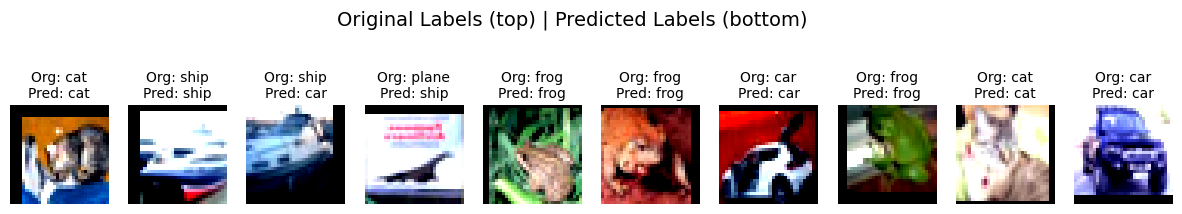

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels for CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Set model to evaluation mode
VIT.eval()

# Prepare to visualize 10 test images
num_images_to_plot = 10
images_shown = 0

# Create a figure
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))
fig.suptitle("Original Labels (top) | Predicted Labels (bottom)", fontsize=14)

for images, labels in test_loader:
    if images_shown >= num_images_to_plot:
        break

    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = VIT(images)
        _, predicted = outputs.max(1)
    
    # For each image in the batch, visualize it
    for i in range(images.size(0)):
        if images_shown >= num_images_to_plot:
            break
        
        img = images[i].cpu().numpy()  # Move to CPU for plotting
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = (img * 0.5) + 0.5  # Undo normalization to [0, 1]

        # Original and predicted labels
        original_label = classes[labels[i].item()]
        predicted_label = classes[predicted[i].item()]
        
        # Plot the image and labels
        axes[images_shown].imshow(img)
        axes[images_shown].axis('off')
        axes[images_shown].set_title(f"Org: {original_label}\nPred: {predicted_label}", fontsize=10)
        
        images_shown += 1

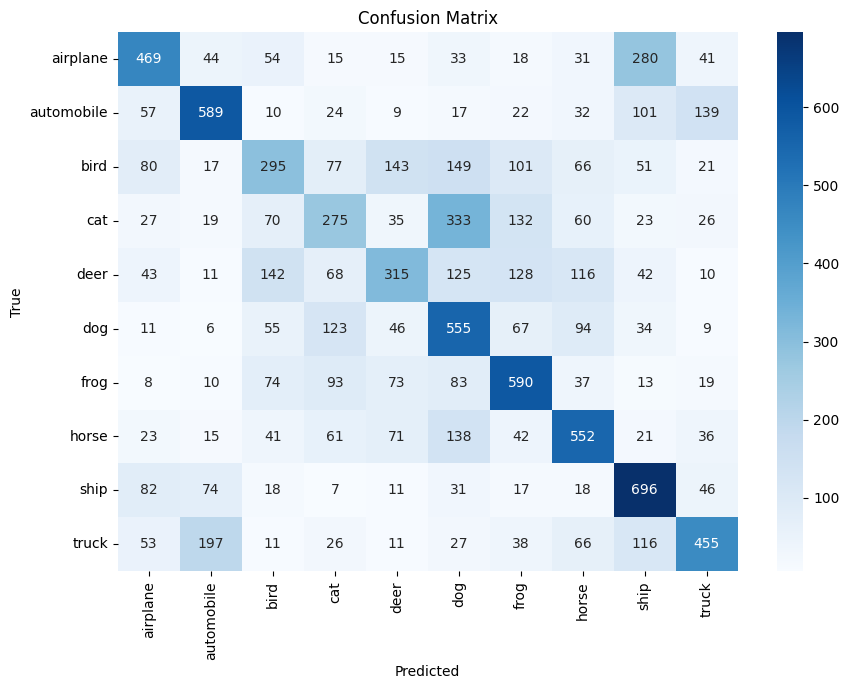

{'0': {'precision': 0.5498241500586166, 'recall': 0.469, 'f1-score': 0.5062061521856448, 'support': 1000}, '1': {'precision': 0.59979633401222, 'recall': 0.589, 'f1-score': 0.5943491422805247, 'support': 1000}, '2': {'precision': 0.38311688311688313, 'recall': 0.295, 'f1-score': 0.3333333333333333, 'support': 1000}, '3': {'precision': 0.3576072821846554, 'recall': 0.275, 'f1-score': 0.3109101187111363, 'support': 1000}, '4': {'precision': 0.43209876543209874, 'recall': 0.315, 'f1-score': 0.3643724696356275, 'support': 1000}, '5': {'precision': 0.3722334004024145, 'recall': 0.555, 'f1-score': 0.4456041750301084, 'support': 1000}, '6': {'precision': 0.5108225108225108, 'recall': 0.59, 'f1-score': 0.5475638051044083, 'support': 1000}, '7': {'precision': 0.5149253731343284, 'recall': 0.552, 'f1-score': 0.5328185328185329, 'support': 1000}, '8': {'precision': 0.5054466230936819, 'recall': 0.696, 'f1-score': 0.5856121161127472, 'support': 1000}, '9': {'precision': 0.5673316708229427, 'recall

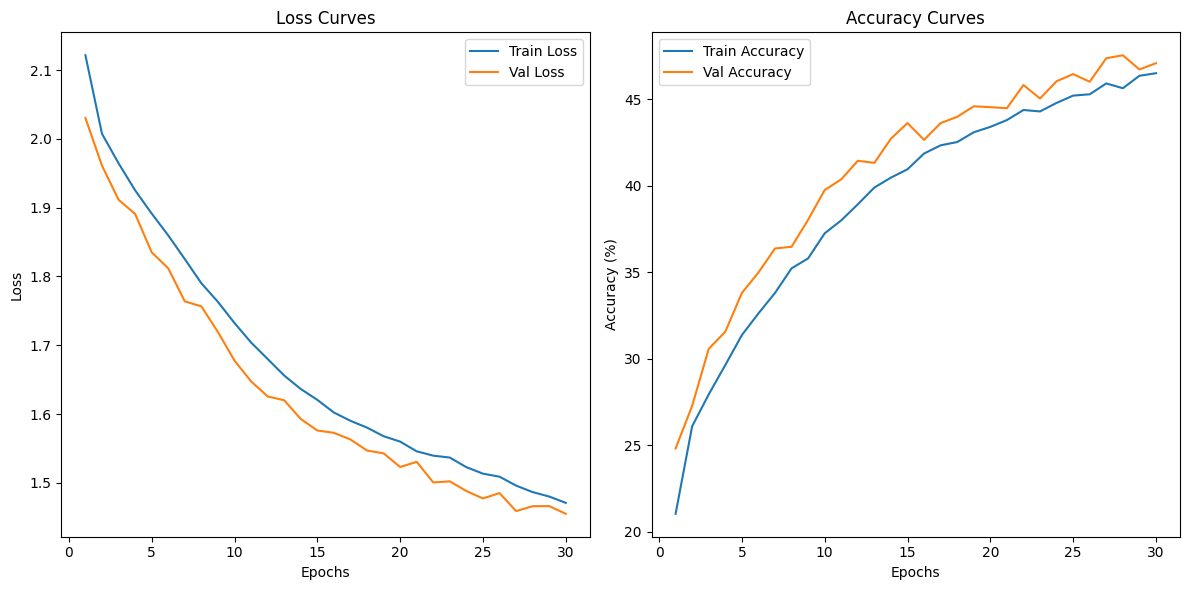

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load the best model weights after training
model.load_state_dict(best_model_wts)

# Evaluate the best model on the test set
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return report, cm

# Assuming you have a test_loader
report, cm = evaluate(model, test_loader)
print(report)

# Plot training and validation loss/accuracy curves
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

### **Custom CNN Model**

In [20]:
class CNN_MLP(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_MLP, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x

In [34]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 30

# Model initialization
Hybrid_model = CNN_MLP(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [35]:
cnn_val_loss=[]
cnn_train_loss=[]
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = 100 * train_correct / total
    cnn_train_loss.append(train_loss)
    # Validation loop
    model.eval()
    val_loss, val_correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Accumulate metrics
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = 100 * val_correct / total
    cnn_val_loss.append(val_loss)
    # Print epoch stats
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/30], Train Loss: 0.5692, Train Acc: 80.13%, Val Loss: 0.6991, Val Acc: 76.20%
Epoch [2/30], Train Loss: 0.5628, Train Acc: 80.43%, Val Loss: 0.7010, Val Acc: 76.02%
Epoch [3/30], Train Loss: 0.5530, Train Acc: 80.61%, Val Loss: 0.6906, Val Acc: 76.76%
Epoch [4/30], Train Loss: 0.5426, Train Acc: 81.23%, Val Loss: 0.6980, Val Acc: 76.76%
Epoch [5/30], Train Loss: 0.5322, Train Acc: 81.42%, Val Loss: 0.7232, Val Acc: 76.46%
Epoch [6/30], Train Loss: 0.5288, Train Acc: 81.40%, Val Loss: 0.7320, Val Acc: 76.00%
Epoch [7/30], Train Loss: 0.5288, Train Acc: 81.43%, Val Loss: 0.6871, Val Acc: 77.35%
Epoch [8/30], Train Loss: 0.5204, Train Acc: 81.69%, Val Loss: 0.6925, Val Acc: 77.11%
Epoch [9/30], Train Loss: 0.5116, Train Acc: 82.14%, Val Loss: 0.7039, Val Acc: 77.00%
Epoch [10/30], Train Loss: 0.5099, Train Acc: 81.96%, Val Loss: 0.6896, Val Acc: 77.21%
Epoch [11/30], Train Loss: 0.5036, Train Acc: 82.20%, Val Loss: 0.7185, Val Acc: 76.48%
Epoch [12/30], Train Loss: 0.4944, Train 

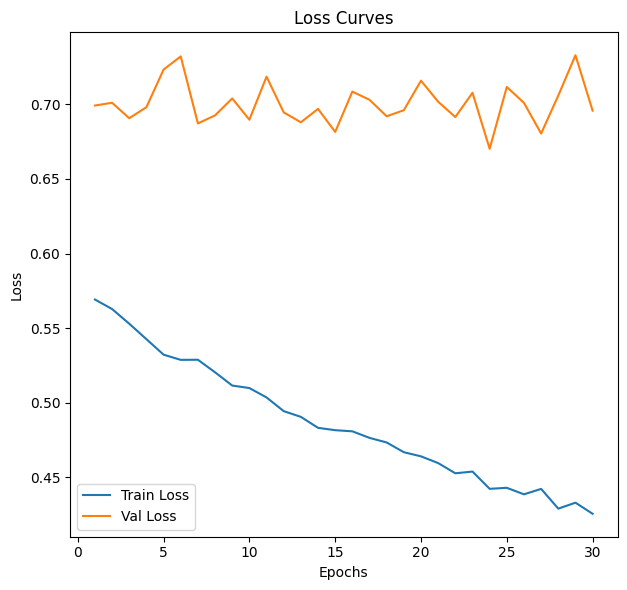

In [36]:
# Plot training and validation loss/accuracy curves
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), cnn_train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), cnn_val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
Hybrid_model.eval()
test_loss, test_correct, total = 0, 0, 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Accumulate metrics
    test_loss += loss.item() * images.size(0)
    _, predicted = outputs.max(1)
    test_correct += (predicted == labels).sum().item()
    total += labels.size(0)

test_loss /= total
test_acc = 100 * test_correct / total
test_acc

78.79

# **Deployment and Plotting**

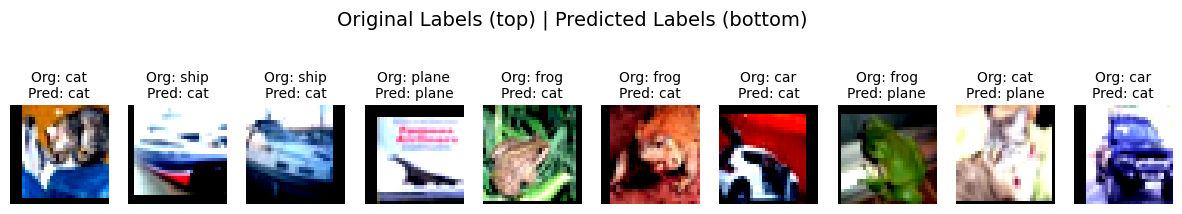

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels for CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Set model to evaluation mode
Hybrid_model.eval()

# Prepare to visualize 10 test images
num_images_to_plot = 10
images_shown = 0

# Create a figure
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))
fig.suptitle("Original Labels (top) | Predicted Labels (bottom)", fontsize=14)

for images, labels in test_loader:
    if images_shown >= num_images_to_plot:
        break

    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = Hybrid_model(images)
        _, predicted = outputs.max(1)
    
    # For each image in the batch, visualize it
    for i in range(images.size(0)):
        if images_shown >= num_images_to_plot:
            break
        
        img = images[i].cpu().numpy()  # Move to CPU for plotting
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = (img * 0.5) + 0.5  # Undo normalization to [0, 1]

        # Original and predicted labels
        original_label = classes[labels[i].item()]
        predicted_label = classes[predicted[i].item()]
        
        # Plot the image and labels
        axes[images_shown].imshow(img)
        axes[images_shown].axis('off')
        axes[images_shown].set_title(f"Org: {original_label}\nPred: {predicted_label}", fontsize=10)
        
        images_shown += 1

In [43]:
torch.save(Hybrid_model, 'Hybrid_model.pth') 

## **Resnet Model FineTuning**

In [29]:
from torchvision import models
#Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 30

# Load pretrained ResNet model
resnet = models.resnet18(pretrained=True)  # Load a ResNet-18 model

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Modify the FC layer for CIFAR-10 (10 classes)
num_features = resnet.fc.in_features  # Get the number of features in the original FC layer
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 256),  # Add an intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)  # Output layer for 10 classes
)
# Transfer model to device
resnet = resnet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=learning_rate)  # Only optimize the new layers

In [30]:
resnet_train_loss=[]
resnet_val_loss=[]
# Training loop
for epoch in range(num_epochs):
    resnet.train()
    train_loss, train_correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = 100 * train_correct / total
    resnet_train_loss.append(train_loss)
    # Validation loop
    resnet.eval()
    val_loss, val_correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            
            # Accumulate metrics
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = 100 * val_correct / total
    resnet_val_loss.append(val_loss)
    # Print epoch stats
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/30], Train Loss: 1.8813, Train Acc: 32.88%, Val Loss: 1.7221, Val Acc: 39.19%
Epoch [2/30], Train Loss: 1.7780, Train Acc: 36.51%, Val Loss: 1.6872, Val Acc: 41.25%
Epoch [3/30], Train Loss: 1.7637, Train Acc: 36.94%, Val Loss: 1.6559, Val Acc: 41.47%
Epoch [4/30], Train Loss: 1.7478, Train Acc: 37.83%, Val Loss: 1.6700, Val Acc: 40.55%
Epoch [5/30], Train Loss: 1.7332, Train Acc: 38.40%, Val Loss: 1.6328, Val Acc: 42.15%
Epoch [6/30], Train Loss: 1.7273, Train Acc: 38.50%, Val Loss: 1.6321, Val Acc: 42.22%
Epoch [7/30], Train Loss: 1.7206, Train Acc: 39.08%, Val Loss: 1.6403, Val Acc: 41.72%
Epoch [8/30], Train Loss: 1.7184, Train Acc: 38.77%, Val Loss: 1.6258, Val Acc: 42.55%
Epoch [9/30], Train Loss: 1.7199, Train Acc: 39.18%, Val Loss: 1.6308, Val Acc: 43.36%
Epoch [10/30], Train Loss: 1.7105, Train Acc: 39.08%, Val Loss: 1.6212, Val Acc: 42.31%
Epoch [11/30], Train Loss: 1.7125, Train Acc: 39.13%, Val Loss: 1.6111, Val Acc: 43.42%
Epoch [12/30], Train Loss: 1.7037, Train 

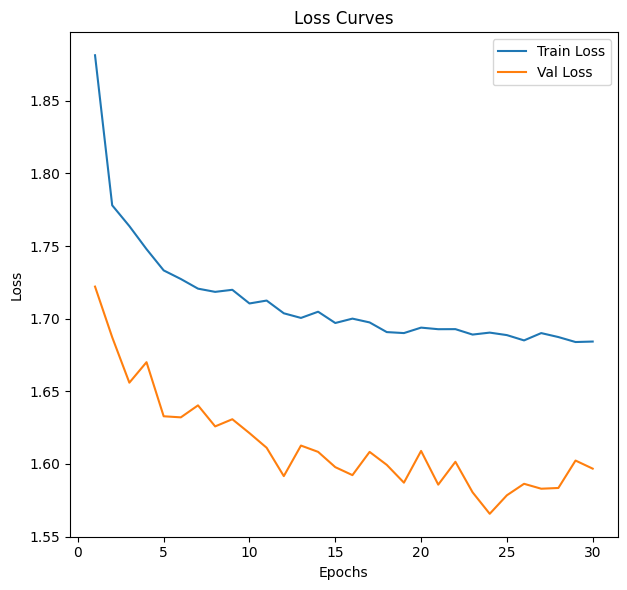

In [32]:
# Plot training and validation loss/accuracy curves
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), resnet_train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), resnet_val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
resnet.eval()
test_loss, test_correct, total = 0, 0, 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    outputs = resnet(images)
    loss = criterion(outputs, labels)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Accumulate metrics
    test_loss += loss.item() * images.size(0)
    _, predicted = outputs.max(1)
    test_correct += (predicted == labels).sum().item()
    total += labels.size(0)

test_loss /= total
test_acc = 100 * test_correct / total
test_acc

44.07

# **Deployment and Plotting**

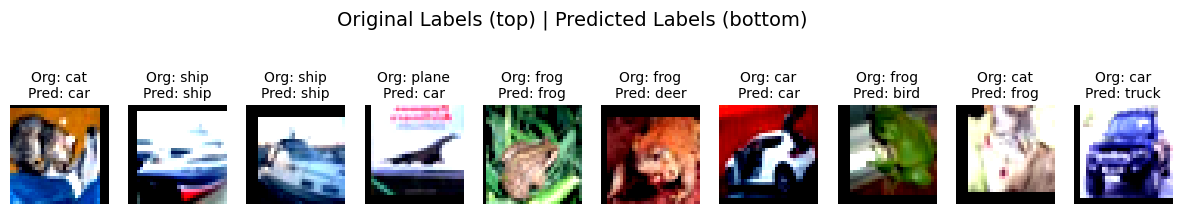

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels for CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Set model to evaluation mode
resnet.eval()

# Prepare to visualize 10 test images
num_images_to_plot = 10
images_shown = 0

# Create a figure
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))
fig.suptitle("Original Labels (top) | Predicted Labels (bottom)", fontsize=14)

for images, labels in test_loader:
    if images_shown >= num_images_to_plot:
        break

    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = resnet(images)
        _, predicted = outputs.max(1)
    
    # For each image in the batch, visualize it
    for i in range(images.size(0)):
        if images_shown >= num_images_to_plot:
            break
        
        img = images[i].cpu().numpy()  # Move to CPU for plotting
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = (img * 0.5) + 0.5  # Undo normalization to [0, 1]

        # Original and predicted labels
        original_label = classes[labels[i].item()]
        predicted_label = classes[predicted[i].item()]
        
        # Plot the image and labels
        axes[images_shown].imshow(img)
        axes[images_shown].axis('off')
        axes[images_shown].set_title(f"Org: {original_label}\nPred: {predicted_label}", fontsize=10)
        
        images_shown += 1

In [44]:
torch.save(resnet, 'resnet_model.pth') 

# **Performance Comparison**

In [42]:
print('------------------- | Classification Accuracy | Training Time | Memory Usage | Inferrence Speed |')
print('Vision Transformer         65%                        15mins          <1GB           <1sec')
print('Resnet Fine Tuning         79%                         21mins         <1GB           <1sec')
print('MLP Hybrid Model           44%                         27mins         <1GB           <1sec')

------------------- | Classification Accuracy | Training Time | Memory Usage | Inferrence Speed |
Vision Transformer         65%                        15mins          <1GB           <1sec
Resnet Fine Tuning         79%                         21mins         <1GB          <1sec
MLP Hybrid Model           44%                         27mins         <1GB          <1sec
